#### Jupyter Notebook to compute performance metrics from the segmentation predictions.


#### Imports

In [3]:
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import os
import imageio
import json
from skimage import transform
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from shutil import copy
from AxonDeepSeg.apply_model import axon_segmentation
from AxonDeepSeg.testing.segmentation_scoring import *
from scipy.misc import imread, imsave
%matplotlib inline

In [4]:
path_img = '/Users/rudinakaprata/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/image.png'

In [42]:
img = imageio.imread(path_img)
path_folder, file_name = os.path.split(path_img)

model_name = 'default_SEM_model_v1'
path_model = os.path.join('..','AxonDeepSeg','models',model_name)
path_configfile = os.path.join(path_model,'config_network.json')
with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())
    
mask = imageio.imread(os.path.join(path_folder,'mask.png'))
gt_axon = mask[:,:,1] > 200
gt_myelin = np.logical_and(mask[:,:,1] >= 50, mask[:,:,1] <= 200)

pred = imageio.imread(os.path.join(path_folder,'AxonDeepSeg.png'))
pred_axon = pred > 200
pred_myelin = np.logical_and(pred >= 50, pred <= 200)

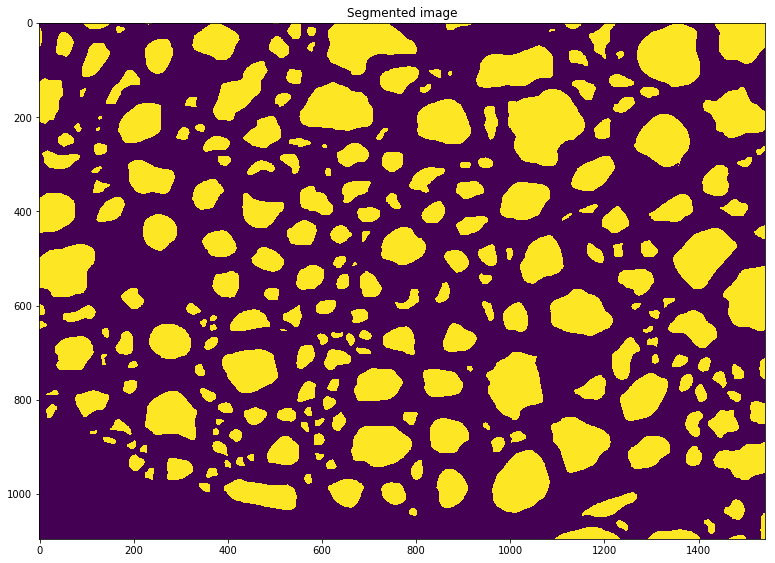

In [49]:
plt.figure(figsize=(13,10))
plt.title('Segmented image')
plt.imshow(gt_axon)
plt.show();

#### Function definitions

In [1]:
def pw_dice(img1, img2):
    """
    img1 and img2 are boolean masks ndarrays
    This functions compute the pixel-wise dice coefficient (not axon-wise but pixel wise)
    """

    img_sum = img1.sum() + img2.sum()
    if img_sum == 0:
        return 1

    intersection = np.logical_and(img1, img2)
    # Return the global dice coefficient
    return 2. * intersection.sum() / img_sum

In [ ]:
def pw_F1_score(img1, img2):
    """
    img1 and img2 are boolean masks ndarrays
    This functions compute the pixel-wise dice coefficient (not axon-wise but pixel wise)
    """

    img_sum = img1.sum() + img2.sum()
    if img_sum == 0:
        return 1

    intersection = np.logical_and(img1, img2)
    # Return the global dice coefficient
    return 2. * intersection.sum() / img_sum

In [64]:
def pw_sensitivity(prediction, groundtruth):

    TP_count = np.logical_and(prediction, groundtruth)
    TP_count = TP_count.sum()

    P_count = prediction.sum()
    
    sensitivity = np.true_divide(TP_count, P_count)
    
    return sensitivity

In [82]:
def pw_precision(prediction, groundtruth):

    TP_count = np.logical_and(prediction, groundtruth)
    plt.imshow(TP_count)
    plt.show();
    TP_count = TP_count.sum()
    print(TP_count)

    FP_count = np.logical_and(prediction == 0 , groundtruth == 1)
    plt.imshow(FP_count)
    plt.show();
    FP_count = FP_count.sum()
    print(FP_count)

    
    
    precision = np.true_divide(TP_count, (TP_count + FP_count))
    
    return precision

477874
507360
0.9418834752444024


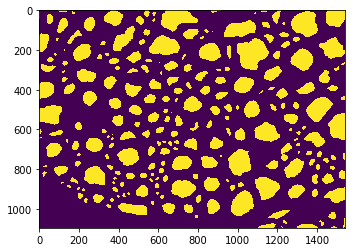

477874


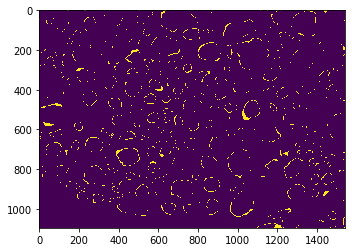

48640
0.9076187907633985


In [83]:
sen = pw_sensitivity(pred_axon,gt_axon)
print(sen)
pre = pw_precision(pred_axon,gt_axon)
print(pre)

In [3]:
def add_multiplicative_gaussian_noise(img,mu=1,sigma=0.05):

    # Generate random gaussian noise with specified mean and sigma values
    noise = np.random.normal(mu, sigma, img.shape)
    
    # Add generated noise to input image
    img_noise = np.multiply(img,noise)

    # Clip noisy image between 0-255
    img_noise[img_noise < 0] = 0
    img_noise[img_noise > 255] = 255

    return img_noise.astype(np.uint8)

In [4]:
def change_illumination(img,value_percentage=0.2):

    # Add generated noise to input image
    img_noise = img+(value_percentage*255)

    # Clip noisy image between 0-255
    img_noise[img_noise < 0] = 0
    img_noise[img_noise > 255] = 255

    return img_noise.astype(np.uint8)

#### Path to change (put path to image to segment)

In [5]:
path_img = '/Users/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/image.png'

#### Set paths for AxonDeepSeg segmentation tools

In [113]:
img = imageio.imread(path_img)
path_folder, file_name = os.path.split(path_img)

model_name = 'default_SEM_model_v1'
path_model = os.path.join('..','AxonDeepSeg','models',model_name)
path_configfile = os.path.join(path_model,'config_network.json')
with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())
    
mask = imageio.imread(os.path.join(path_folder,'mask.png'))
gt_axon = mask > 200
gt_myelin = np.logical_and(mask >= 50, mask <= 200)

#### 1) Batch for simulation of illumination change:

- For all noise values, generates noisy image, creates sub-folder, saves noisy image, launches AxonDeepSeg segmentation on noisy image, computes and saves prediction accuracy.

In [21]:
values = np.linspace(0,0.8,9)
dice_axon_array = np.empty(0)
dice_myelin_array = np.empty(0)
img_array = []
pred_array = []

for value_percentage in values:
    
    # Generate and save noisy image
    img_noise = change_illumination(img,value_percentage)
    file_name = 'image_' + str(int(value_percentage*100)) + '.png'
    directory_name = 'image_' + str(int(value_percentage*100))
    os.makedirs(os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), os.path.join(path_folder,directory_name))
    imageio.imwrite(os.path.join(path_folder,directory_name,file_name),img_noise)
    img_array.append(img_noise[100:400,100:400])
    
    # Segment noisy image with AxonDeepSeg
    path_testing = os.path.join(path_folder,directory_name)
    prediction = axon_segmentation(path_testing, file_name, path_model, config_network,verbosity_level=0)
    
    # Compute prediction accuracy
    prediction = imread(os.path.join(path_folder,directory_name,'AxonDeepSeg.png'),flatten=True)
    pred_array.append(prediction[100:400,100:400])
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)
    dice_axon, dice_myelin = pw_dice(pred_axon, gt_axon),pw_dice(pred_myelin, gt_myelin)
    dice_axon_array = np.append(dice_axon_array, [dice_axon], axis=0)
    dice_myelin_array = np.append(dice_myelin_array, [dice_myelin], axis=0)
    dict_metrics = {'dice_axon': dice_axon, 'dice_myelin': dice_myelin}
    f = open(os.path.join(path_folder,directory_name,'metrics.txt'), 'w')
    f.write('segmentation metrics: ' + repr(dict_metrics) + '\n')
    f.close()

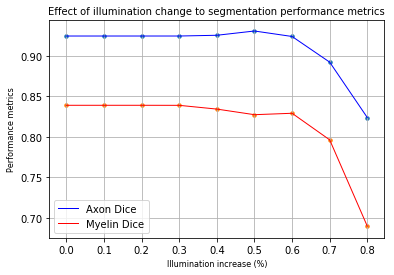

In [100]:
plt.figure()
plt.plot(values, dice_axon_array, 'b', lw=1)
plt.scatter(values, dice_axon_array, s=12)
plt.hold(True) 
plt.plot(values, dice_myelin_array, 'r', lw=1)
plt.scatter(values, dice_myelin_array, s=12)
plt.xlabel('Illumination increase (%)',fontsize=8)
plt.ylabel('Performance metrics',fontsize=8)
plt.title('Effect of illumination change to segmentation performance metrics',fontsize=10)
plt.legend(['Axon Dice','Myelin Dice'])
#plt.xlim(0, 0.3)
plt.grid(True)

Text(0.5,0.98,u'Illumination increase')

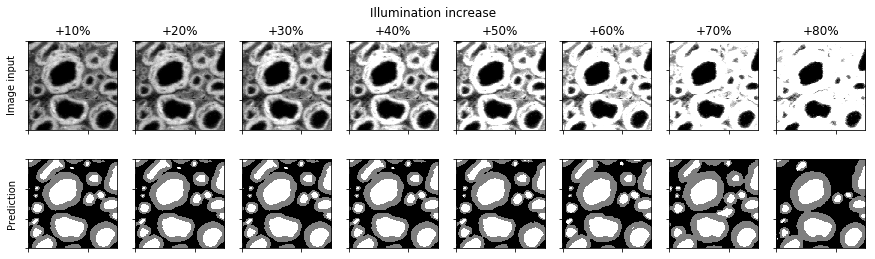

In [101]:
fig = plt.figure(figsize=(15,4))
items = np.arange(1,values.size)

for pos in items:

    plt.subplot(2,items.size,pos)
    plt.imshow(img_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    plt.title('+%s%%'%(int(values[pos]*100)))
    
    if pos==1:
        plt.ylabel('Image input',fontsize=10)

    plt.subplot(2,items.size,pos+items.size)
    plt.imshow(pred_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([]) 
    
    if pos==1:
        plt.ylabel('Prediction',fontsize=10)
    
plt.suptitle("Illumination increase", fontsize=12)  



#### 2) Batch for simulation of gaussian additive noise:

- For all noise values, generates noisy image, creates sub-folder, saves noisy image, launches AxonDeepSeg segmentation on noisy image, computes and saves prediction accuracy.

In [102]:
values = np.linspace(0,30,9)
dice_axon_array = np.empty(0)
dice_myelin_array = np.empty(0)
img_array = []
pred_array = []

for sigma_values in values:
    
    # Generate and save noisy image
    img_noise = add_additive_gaussian_noise(img,0,sigma_values)
    file_name = 'image_' + str(int(sigma_values)) + '.png'
    directory_name = 'image_add_' + str(int(sigma_values))
    os.makedirs(os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), os.path.join(path_folder,directory_name))
    imageio.imwrite(os.path.join(path_folder,directory_name,file_name),img_noise)
    img_array.append(img_noise[100:400,100:400])
    
    # Segment noisy image with AxonDeepSeg
    path_testing = os.path.join(path_folder,directory_name)
    prediction = axon_segmentation(path_testing, file_name, path_model, config_network,verbosity_level=0)
    
    # Compute prediction accuracy
    prediction = imread(os.path.join(path_folder,directory_name,'AxonDeepSeg.png'),flatten=True)
    pred_array.append(prediction[100:400,100:400])
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)
    dice_axon, dice_myelin = pw_dice(pred_axon, gt_axon),pw_dice(pred_myelin, gt_myelin)
    dice_axon_array = np.append(dice_axon_array, [dice_axon], axis=0)
    dice_myelin_array = np.append(dice_myelin_array, [dice_myelin], axis=0)
    dict_metrics = {'dice_axon': dice_axon, 'dice_myelin': dice_myelin}
    f = open(os.path.join(path_folder,directory_name,'metrics.txt'), 'w')
    f.write('segmentation metrics: ' + repr(dict_metrics) + '\n')
    f.close()
    

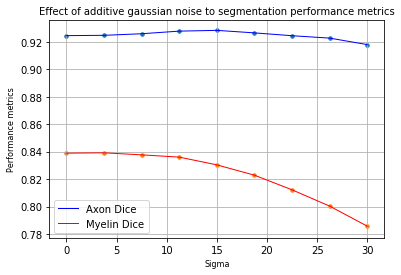

In [103]:
plt.figure()
plt.plot(values, dice_axon_array, 'b', lw=1)
plt.scatter(values, dice_axon_array, s=12)
plt.hold(True) 
plt.plot(values, dice_myelin_array, 'r', lw=1)
plt.scatter(values, dice_myelin_array, s=12)
plt.xlabel('Sigma',fontsize=8)
plt.ylabel('Performance metrics',fontsize=8)
plt.title('Effect of additive gaussian noise to segmentation performance metrics',fontsize=10)
plt.legend(['Axon Dice','Myelin Dice'])
#plt.xlim(0, 0.3)
plt.grid(True)

Text(0.5,0.98,u'Sigma of additive gaussian noise')

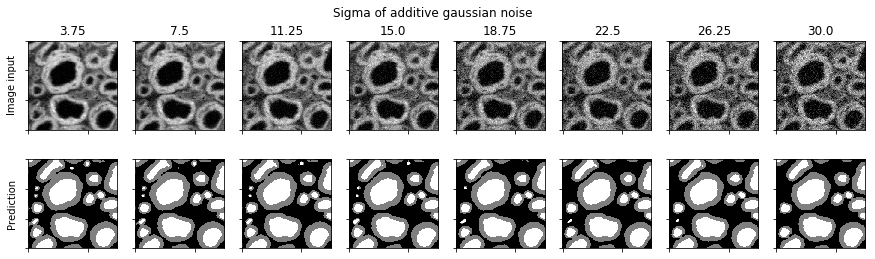

In [109]:
fig = plt.figure(figsize=(15,4))
items = np.arange(1,values.size)

for pos in items:

    plt.subplot(2,items.size,pos)
    plt.imshow(img_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    plt.title('%s'%((values[pos])))
    
    if pos==1:
        plt.ylabel('Image input',fontsize=10)

    plt.subplot(2,items.size,pos+items.size)
    plt.imshow(pred_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([]) 
    
    if pos==1:
        plt.ylabel('Prediction',fontsize=10)
    
plt.suptitle("Sigma of additive gaussian noise", fontsize=12)  



#### 3) Batch for simulation of gaussian multiplicative noise:

- For all noise values, generates noisy image, creates sub-folder, saves noisy image, launches AxonDeepSeg segmentation on noisy image, computes and saves prediction accuracy.

In [110]:
values = np.linspace(0,0.5,9)
dice_axon_array = np.empty(0)
dice_myelin_array = np.empty(0)
img_array = []
pred_array = []

for sigma_values in values:
    
    # Generate and save noisy image
    img_noise = add_multiplicative_gaussian_noise(img,1,sigma_values)
    file_name = 'image_' + str(int(sigma_values*1000)) + '.png'
    directory_name = 'image_mul_' + str(int(sigma_values*100))
    os.makedirs(os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), os.path.join(path_folder,directory_name))
    imageio.imwrite(os.path.join(path_folder,directory_name,file_name),img_noise)
    img_array.append(img_noise[100:400,100:400])
    
    # Segment noisy image with AxonDeepSeg
    path_testing = os.path.join(path_folder,directory_name)
    prediction = axon_segmentation(path_testing, file_name, path_model, config_network,verbosity_level=0)
    
    # Compute prediction accuracy
    prediction = imread(os.path.join(path_folder,directory_name,'AxonDeepSeg.png'),flatten=True)
    pred_array.append(prediction[100:400,100:400])
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)
    dice_axon, dice_myelin = pw_dice(pred_axon, gt_axon),pw_dice(pred_myelin, gt_myelin)
    dice_axon_array = np.append(dice_axon_array, [dice_axon], axis=0)
    dice_myelin_array = np.append(dice_myelin_array, [dice_myelin], axis=0)
    dict_metrics = {'dice_axon': dice_axon, 'dice_myelin': dice_myelin}
    f = open(os.path.join(path_folder,directory_name,'metrics.txt'), 'w')
    f.write('segmentation metrics: ' + repr(dict_metrics) + '\n')
    f.close()

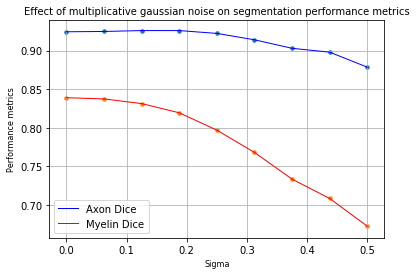

In [111]:
plt.figure()
plt.plot(values, dice_axon_array, 'b', lw=1)
plt.scatter(values, dice_axon_array, s=12)
plt.hold(True) 
plt.plot(values, dice_myelin_array, 'r', lw=1)
plt.scatter(values, dice_myelin_array, s=12)
plt.xlabel('Sigma',fontsize=8)
plt.ylabel('Performance metrics',fontsize=8)
plt.title('Effect of multiplicative gaussian noise on segmentation performance metrics',fontsize=10)
plt.legend(['Axon Dice','Myelin Dice'])
#plt.xlim(0, 0.3)
plt.grid(True)

Text(0.5,0.98,u'Sigma of multiplicative gaussian noise')

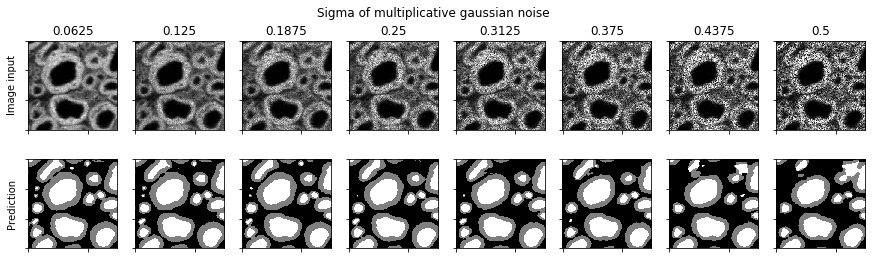

In [112]:
fig = plt.figure(figsize=(15,4))
items = np.arange(1,values.size)

for pos in items:

    plt.subplot(2,items.size,pos)
    plt.imshow(img_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    plt.title('%s'%((values[pos])))
    
    if pos==1:
        plt.ylabel('Image input',fontsize=10)

    plt.subplot(2,items.size,pos+items.size)
    plt.imshow(pred_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([]) 
    
    if pos==1:
        plt.ylabel('Prediction',fontsize=10)
    
plt.suptitle("Sigma of multiplicative gaussian noise", fontsize=12)  

